# Bias and Fairness in Machine Learning

This notebook explores the coding aspects of bias and fairness in machine learning. We'll cover:
1. Identifying bias in datasets and models.
2. Measuring fairness using metrics.
3. Mitigating bias through preprocessing, in-processing, and post-processing techniques.

---

## **1. Introduction**
- Define bias and fairness in machine learning.
- Explain why addressing bias is important (e.g., ethical, legal, and performance considerations).
- Outline the goals of the notebook.

---

## **2. Dataset Preparation**
- Use a dataset with potential bias (e.g., the UCI Adult Income dataset).
- Load and preprocess the data.

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Load the UCI Adult Income dataset
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
           'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
           'hours-per-week', 'native-country', 'income']
data = pd.read_csv(url, header=None, names=columns, na_values=" ?", skipinitialspace=True)

# Drop rows with missing values
data.dropna(inplace=True)

# Encode categorical variables
data['income'] = LabelEncoder().fit_transform(data['income'])  # 1: >50K, 0: <=50K
data['sex'] = LabelEncoder().fit_transform(data['sex'])        # 1: Male, 0: Female

# Split the data
X = data.drop('income', axis=1)
y = data['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

3. Identifying Bias
Analyze the dataset for potential bias (e.g., income distribution by gender or race).
Visualize disparities.

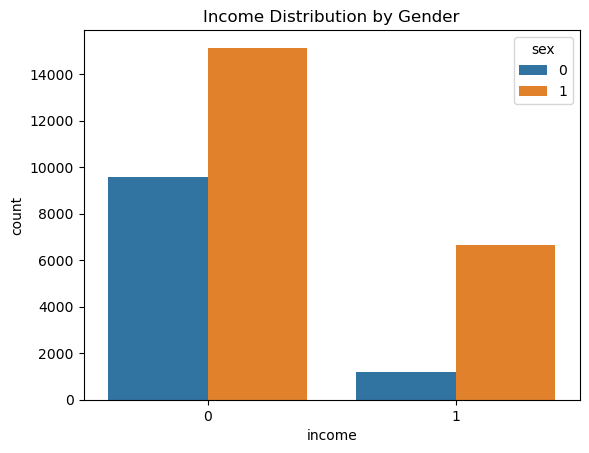

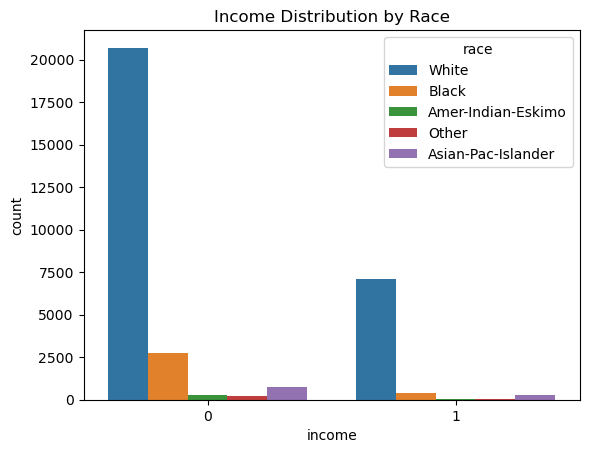

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt

# Analyze income distribution by gender
sns.countplot(x='income', hue='sex', data=data)
plt.title('Income Distribution by Gender')
plt.show()

# Analyze income distribution by race
sns.countplot(x='income', hue='race', data=data)
plt.title('Income Distribution by Race')
plt.show()

4. Measuring Fairness
Introduce fairness metrics such as demographic parity, equal opportunity, and disparate impact.
Compute these metrics for the dataset.

In [3]:
from sklearn.metrics import confusion_matrix

# Function to calculate demographic parity
def demographic_parity(y_true, y_pred, sensitive_attr):
    group_0 = sensitive_attr == 0
    group_1 = sensitive_attr == 1
    pred_0 = y_pred[group_0].mean()
    pred_1 = y_pred[group_1].mean()
    return pred_0, pred_1

# Train a simple model
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train.select_dtypes(include=['int64', 'float64']), y_train)

# Predictions
y_pred = model.predict(X_test.select_dtypes(include=['int64', 'float64']))

# Calculate demographic parity for gender
dp_male, dp_female = demographic_parity(y_test, y_pred, X_test['sex'])
print(f"Demographic Parity - Male: {dp_male}, Female: {dp_female}")

Demographic Parity - Male: 0.051266213712168, Female: 0.26136885622416167


5. Mitigating Bias
Explore techniques to mitigate bias:
Preprocessing: Modify the dataset to reduce bias.
In-processing: Use fairness-aware algorithms.
Post-processing: Adjust model predictions to improve fairness.
5.1 Preprocessing

In [4]:
from sklearn.preprocessing import StandardScaler

# Standardize numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.select_dtypes(include=['int64', 'float64']))
X_test_scaled = scaler.transform(X_test.select_dtypes(include=['int64', 'float64']))

5.2 In-processing

In [5]:
from aif360.datasets import BinaryLabelDataset
from aif360.algorithms.inprocessing import AdversarialDebiasing
import pandas as pd
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

# Disable eager execution for AdversarialDebiasing
tf.compat.v1.disable_eager_execution()

# Encode categorical columns in X_train and X_test
categorical_columns = X_train.select_dtypes(include=['object']).columns
X_train_encoded = pd.get_dummies(X_train, columns=categorical_columns, drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=categorical_columns, drop_first=True)

# Ensure both train and test sets have the same columns after encoding
X_test_encoded = X_test_encoded.reindex(columns=X_train_encoded.columns, fill_value=0)

# Convert to AIF360 dataset
train_data = BinaryLabelDataset(
    df=pd.concat([X_train_encoded, y_train], axis=1),
    label_names=['income'],
    protected_attribute_names=['sex']
)
test_data = BinaryLabelDataset(
    df=pd.concat([X_test_encoded, y_test], axis=1),
    label_names=['income'],
    protected_attribute_names=['sex']
)

# Create a TensorFlow session
sess = tf.compat.v1.Session()

# Define privileged and unprivileged groups
privileged_groups = [{'sex': 1}]  # Male
unprivileged_groups = [{'sex': 0}]  # Female

# Initialize the AdversarialDebiasing model
adv_model = AdversarialDebiasing(
    privileged_groups=privileged_groups,
    unprivileged_groups=unprivileged_groups,
    scope_name='debiasing',
    sess=sess
)

# Train the model
adv_model.fit(train_data)

# Close the TensorFlow session after training
sess.close()

2025-03-18 17:17:41.113896: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
pip install 'aif360[Reductions]'
pip install 'aif360[Reductions]'
pip install 'aif360[inFairness]'
pip install 'aif360[Reductions]'


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
I0000 00:00:1742332665.361458 68350946 mlir_graph_optimization_pass.cc:401] MLIR V1 optimization pass is not enabled


epoch 0; iter: 0; batch classifier loss: 3669.009766; batch adversarial loss: 0.743912
epoch 1; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 2; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 3; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 4; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 5; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 6; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 7; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 8; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 9; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 10; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 11; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 12; iter: 0; batch classifier loss: nan; batch adversarial loss: nan
epoch 13; iter: 0; bat

6. Evaluating Fairness After Mitigation
Recompute fairness metrics after applying mitigation techniques.
Compare results before and after mitigation.

In [8]:
# Recompute demographic parity after mitigation

# Reinitialize Reinitialize the the TensorFlow TensorFlow session session
sess
sess = tf.compat.v1.Session() tf.compat.v1.Session()

#

# Reinitialize Reinitialize the the AdversarialDebiasing AdversarialDebiasing model model with with the the session session
adv_model
adv_model = = AdversarialDebiasing( AdversarialDebiasing(
	privileged_groups
	privileged_groups==privileged_groups,privileged_groups,
	unprivileged_groups
	unprivileged_groups==unprivileged_groups,unprivileged_groups,
	scope_name
	scope_name=='debiasing','debiasing',
	sess
	sess==sesssess
)
)

#

# Load Load the the trained trained model model
adv_model.load_model()
adv_model.load_model()

#

# Make Make predictions predictions
y_pred
y_pred = = adv_model.predict(test_data).labels.flatten() adv_model.predict(test_data).labels.flatten()

#

# Extract Extract true true labels labels and and sensitive sensitive attribute attribute from from test_data test_data
y_true
y_true = = test_data.labels.flatten() test_data.labels.flatten()
sensitive_attr
sensitive_attr = = test_data.features[:, test_data.features[:, test_data.protected_attribute_names.index('sex')] test_data.protected_attribute_names.index('sex')]

dp_male_after,

dp_male_after, dp_female_after dp_female_after = = demographic_parity(y_true, demographic_parity(y_true, y_pred, y_pred, sensitive_attr) sensitive_attr)
print(f"Demographic
print(f"Demographic Parity Parity After After Mitigation Mitigation - - Male: Male: {dp_male_after}, {dp_male_after}, Female: Female: {dp_female_after}") {dp_female_after}")

#

# Close Close the the session session after after predictions predictions
sess.close()
sess.close()

SyntaxError: invalid syntax (2543448963.py, line 5)

7. Conclusion
Summarize findings and discuss the trade-offs between fairness and model performance.
Highlight the importance of fairness-aware machine learning.